


**Author:** Steffen Schober



## Acknowlegment



This notebook is based on the DASK tutorial.



## Prepare Data



Prepare the data, make sure that `prep.py` is the same directory than this notebook.



In [2]:
%run prep.py -d flights

In [3]:
%run prep.py -d accounts

## Setup



In [4]:
from dask.distributed import Client

client = Client(n_workers=4)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 12,Total memory: 31.72 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:50088,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 12
Started: Just now,Total memory: 31.72 GiB
Comm: tcp://127.0.0.1:50117,Total threads: 3
Dashboard: http://127.0.0.1:50118/status,Memory: 7.93 GiB
Nanny: tcp://127.0.0.1:50095,


You can access the dashboard using your web browser, the linke is also found here:



In [5]:
print(client.cluster.dashboard_link)

http://127.0.0.1:8787/status


Explore the dashboard, you can find a lot of information there.
Note that under `Info` you find information about
the TCP endpoint of the scheduler (you can use this to connect to the cluster via the `Client`.).



## First Example - Loading CSV file



In [6]:
import os
import dask
filename = os.path.join('data', 'accounts.*.csv')
filename

'data\\accounts.*.csv'

In [7]:
import dask.dataframe as dd
df = dd.read_csv(filename)
df.head()

,id,names,amount
0,216,Dan,-1
1,370,Victor,-44
2,223,Yvonne,507
3,96,Kevin,334
4,417,Norbert,193


In [8]:
# load and count number of rows
len(df)

3000000

## Flights Data Set



In [9]:
# load and count number of rows
df = dd.read_csv(os.path.join('data', 'nycflights', '*.csv'),
  	       parse_dates={'Date': [0, 1, 2]},
  	       dtype={'TailNum': str,
  		      'CRSElapsedTime': float,
  		      'Cancelled': bool}
)
df

,Date,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
npartitions=10,,,,,,,,,,,,,,,,,,,,,
,datetime64[ns],int64,float64,int64,float64,int64,object,int64,object,float64,float64,float64,float64,float64,object,object,float64,float64,float64,bool,int64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


Notice that the representation of the dataframe object contains no data - Dask has just done enough to read the start of the first file, and infer the column names and dtypes.
We enforce the dtype for three columns, because those do not contain data in the first rows, hence,
type inference will fail&#x2026; (you can check this by omitting the `dtype` in `read_csv()`).



In [10]:
df.dtypes

Date                 datetime64[ns]
DayOfWeek                     int64
DepTime                     float64
CRSDepTime                    int64
ArrTime                     float64
CRSArrTime                    int64
UniqueCarrier                object
FlightNum                     int64
TailNum                      object
ActualElapsedTime           float64
CRSElapsedTime              float64
AirTime                     float64
ArrDelay                    float64
DepDelay                    float64
Origin                       object
Dest                         object
Distance                    float64
TaxiIn                      float64
TaxiOut                     float64
Cancelled                      bool
Diverted                      int64
dtype: object

In [11]:
df.head()

,Date,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,...,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
0,1990-01-01,1,1621.0,1540,1747.0,1701,US,33,NaN,86.0,...,NaN,46.0,41.0,EWR,PIT,319.0,NaN,NaN,False,0
1,1990-01-02,2,1547.0,1540,1700.0,1701,US,33,NaN,73.0,...,NaN,-1.0,7.0,EWR,PIT,319.0,NaN,NaN,False,0
2,1990-01-03,3,1546.0,1540,1710.0,1701,US,33,NaN,84.0,...,NaN,9.0,6.0,EWR,PIT,319.0,NaN,NaN,False,0
3,1990-01-04,4,1542.0,1540,1710.0,1701,US,33,NaN,88.0,...,NaN,9.0,2.0,EWR,PIT,319.0,NaN,NaN,False,0
4,1990-01-05,5,1549.0,1540,1706.0,1701,US,33,NaN,77.0,...,NaN,5.0,9.0,EWR,PIT,319.0,NaN,NaN,False,0


Unlike `pandas.read_csv` which reads in the entire file before inferring datatypes,
`dask.dataframe.read_csv` only reads in a sample from the beginning of the file (or first file if using a glob).
These inferred datatypes are then enforced when reading all partitions.



### Some Analysis



We compute the maximum of the `DepDelay` column. With just pandas, we would loop over each file to find the individual maximums, then find the final maximum over all the individual maximums

    maxes = []
    for fn in filenames:
        df = pd.read_csv(fn)
        maxes.append(df.DepDelay.max())
    
    final_max = max(maxes)

We could wrap that `pd.read_csv` with `dask.delayed` so that it runs in parallel.
Regardless, we’re still having to think about loops, intermediate results (one per file) and the final reduction (max of the intermediate maxes).

    df = pd.read_csv(filename, dtype=dtype)
    df.DepDelay.max()

`dask.dataframe` lets us write pandas-like code, that operates on larger than memory datasets in parallel.
Here we compute the max of `DepDelay`:



In [12]:
%time df.DepDelay.max().compute()

CPU times: total: 312 ms
Wall time: 2.74 s


1435.0

Let's visualize the graph:



In [13]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'

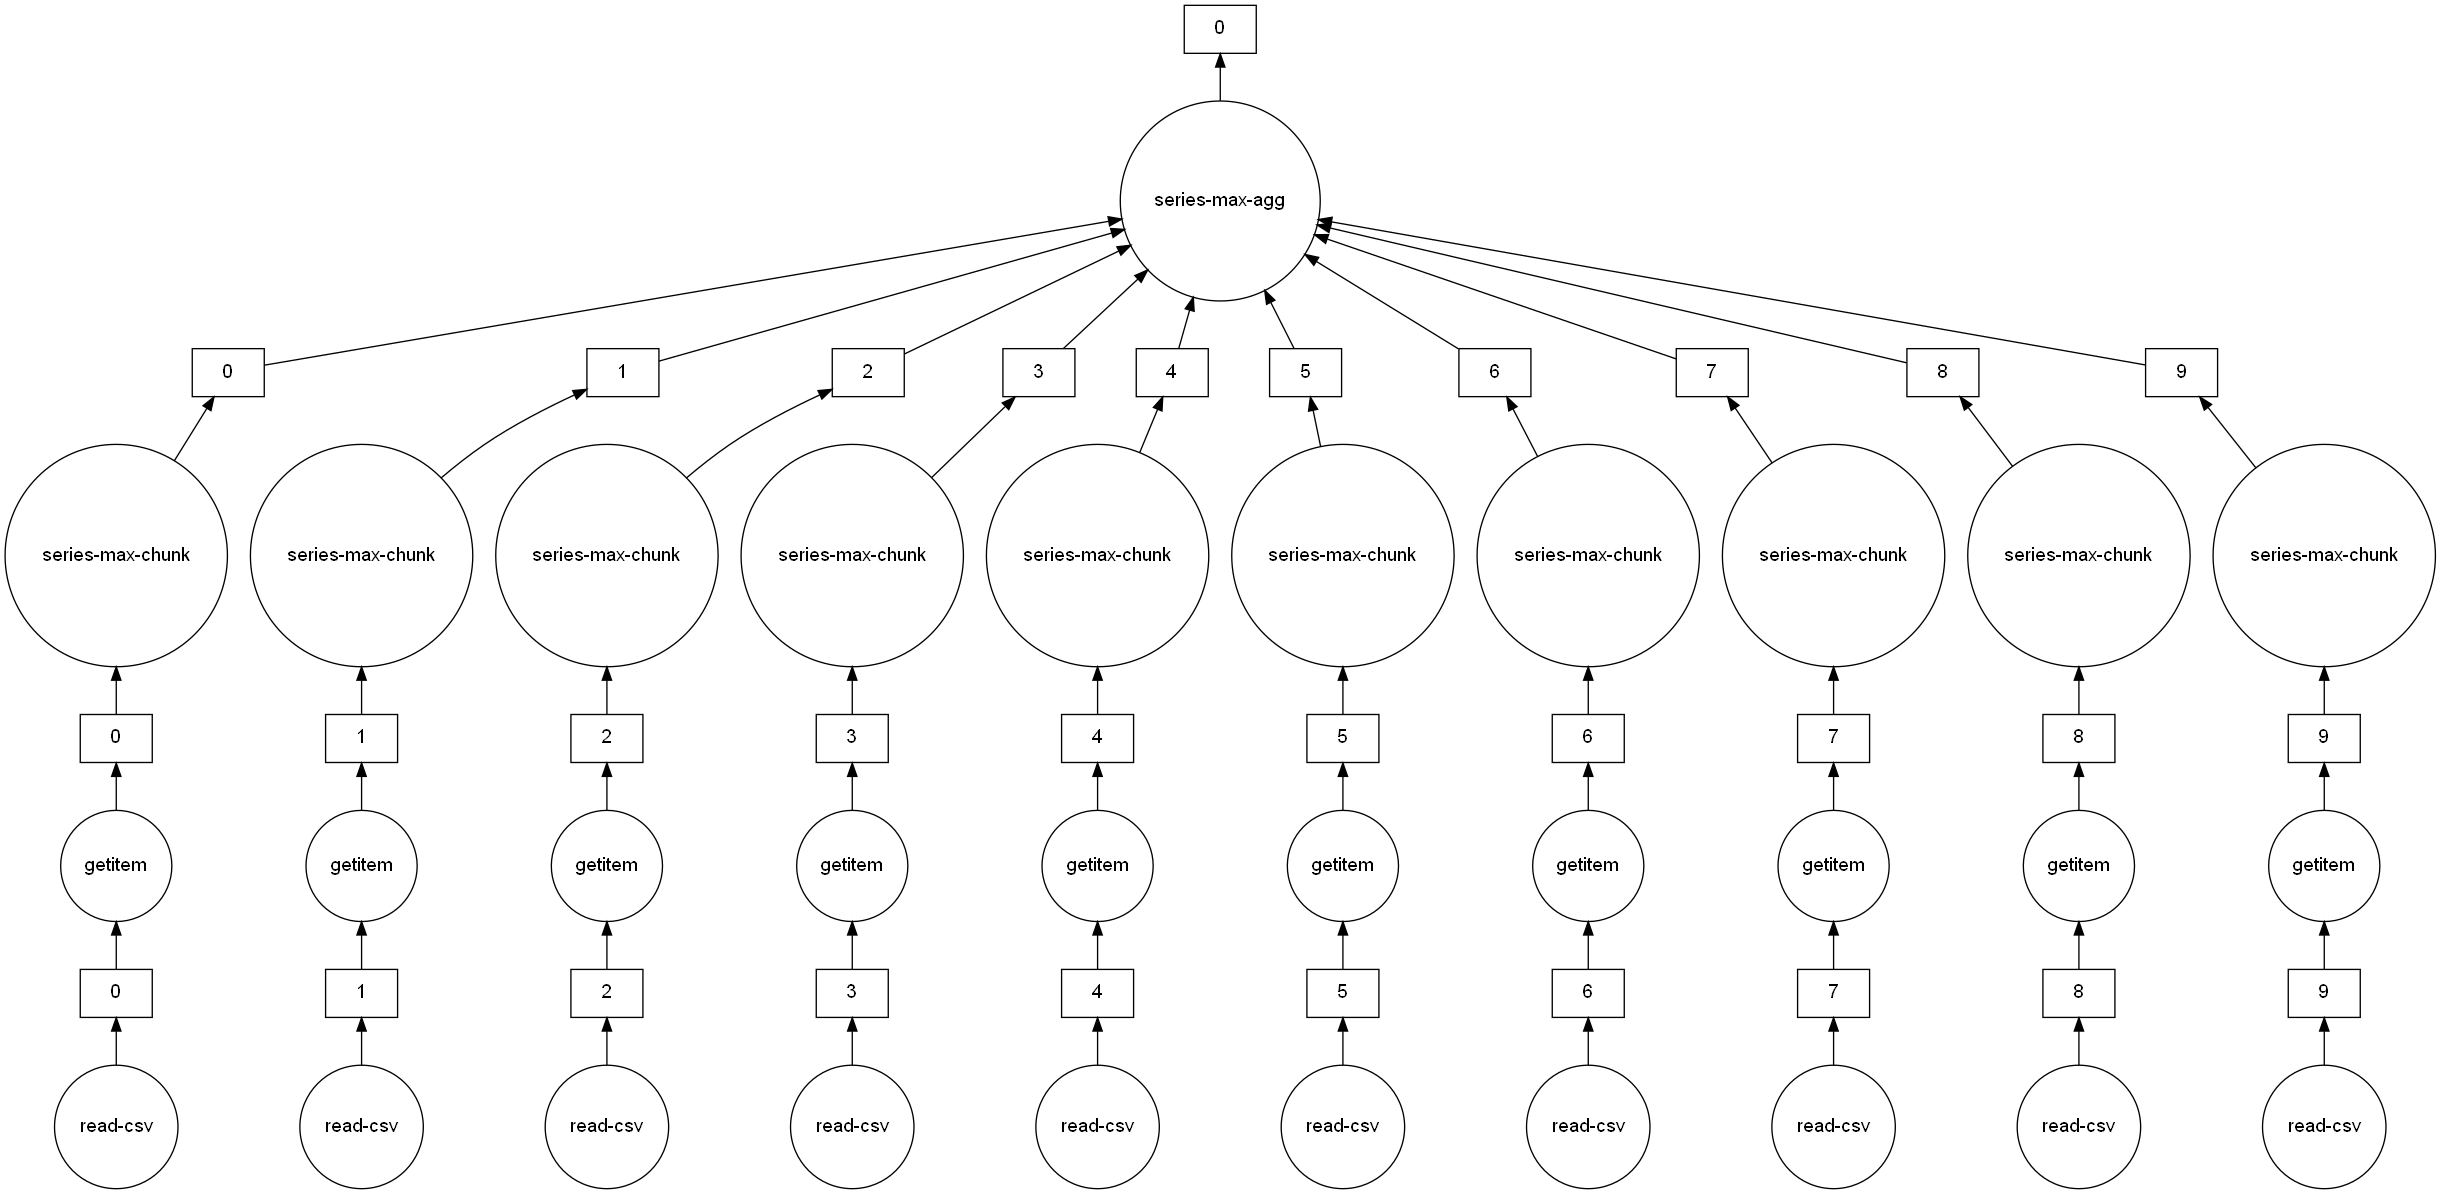

In [14]:
# notice the parallelism
df.DepDelay.max().visualize()

## Exercises



Try to answer the following questions:

1.  How many rows are in our dataset?
2.  In total, how many non-canceled flights were taken?
3.  In total, how many non-cancelled flights were taken from each airport?
4.  What day of the week has the worst average departure delay?

Hint for the third question:
use `groupby` with the aggregate function `count`.
See [https://pandas.pydata.org/pandas-docs/stable/groupby.html](https://pandas.pydata.org/pandas-docs/stable/groupby.html).



In [15]:
# 1: How many rows are in our dataset?
print(f"Row count: {len(df):,}")

Row count: 2,611,892


In [16]:
# In total, how many non-canceled flights were taken?
print(f"Flights taken (not cancelled): {len(df[df.Cancelled==False]):,}")
print(f"Percentage (not cancelled): {len(df[df.Cancelled==False]) / len(df)}")

Flights taken (not cancelled): 2,540,961
Percentage (not cancelled): 0.9728430578293437


In [17]:
print(df[df.Cancelled==False].groupby("Origin")["Origin"].count().compute())

Origin
EWR    1139451
JFK     427243
LGA     974267
Name: Origin, dtype: int64


In [18]:
dayStrings = {1: "Mon", 2: "Tue", 3: "Wed",4: "Thu", 5: "Fri", 6: "Sat", 7: "Sun"}
# groupby "DayOfWeek"
dayGroups = df[df.Cancelled==False].groupby("DayOfWeek")
# calc avg of "DepDelay"
daysWithAvgDelay = dayGroups["DepDelay"].mean().rename(index=dayStrings).compute()
print(daysWithAvgDelay)

DayOfWeek
Mon     8.096565
Tue     8.149109
Wed     9.141912
Thu    10.538275
Fri    11.476687
Sat     7.824071
Sun     8.994296
Name: DepDelay, dtype: float64


In [19]:
maxIndex = daysWithAvgDelay.index[daysWithAvgDelay == daysWithAvgDelay.max()]
print(f"Day with the highest delay is: {maxIndex.values[0]}, having a average delay of {daysWithAvgDelay[maxIndex.values[0]]:.4} min")


Day with the highest delay is: Fri, having a average delay of 11.48 min


## Sharing Intermediate Results



When computing all of the above, we sometimes did the same operation more than once.
For most operations, `dask.dataframe` hashes the arguments, allowing duplicate computations to be shared, and only computed once.

For example, lets compute the mean and standard deviation for departure delay of all non-canceled flights.
Since dask operations are lazy, those values aren’t the final results yet. They’re just the recipe required to get the result.

If we compute them with two calls to compute, there is no sharing of intermediate computations.



In [20]:
non_cancelled = df[~df.Cancelled]
mean_delay = non_cancelled.DepDelay.mean()
std_delay = non_cancelled.DepDelay.std()

In [21]:
%%time

mean_delay_res = mean_delay.compute()
std_delay_res = std_delay.compute()

CPU times: total: 625 ms
Wall time: 5.62 s


But let’s try by passing both to a single compute call.



In [22]:
%%time
mean_delay_res, std_delay_res = dask.compute(mean_delay, std_delay)

CPU times: total: 609 ms
Wall time: 2.82 s


The task graphs for both results are merged when calling `dask.compute`, allowing shared operations to only be done once instead of twice.

